# Study wavelet-filtered traces

* **Objective**: calibrate the sorting of the wavelet-filtered traces with kilosort3.

* **Approach**:
    * We compared sorting on wavelet-filtered traces and butterworth-filtered traces for the silico marques experiment, on a 5 min sample, for speed.
        * their single unit and multi-unit yields.
        * their unit sorting accuracies curves

* **Method**
    * <u>no KS3 butterworth filtering</u>: skip_preprocessing=False, comment the filter commands in Kilosort3's `gpufilter.m` file
    * <u>no drift correction</u>:
    * <u>detection_threshold=138</u> calibrated to maximize spike detection (w/o mexWtW2 max variable size crash):
    * notes:
        * KS3 crashes with default parameters because the number of spikes detected is beyond the Maximum variable size allowed on the device (in mexWtW2).
        * we skip drift correction (drift_correction=False), else "Error using histcounts - Expected input number 2, edges, to be monotonically increasing".

* to skip preprocessing, we need to comment the filter commands in Kilosort3's `gpufilter.m` file (skip_preprocessing=True crashes because the whitening commands in preprocessDataSub are needed, and it skips them)


* **Method**:  
    * RecordingExtractor must be cast cast int16 before sorting with Kilosort3 (sorting takes 10 min instead of 2h for float64)
    * sorts up to 11119 units then crashes with error:
        * ----------------------------------------Error using mexWtW2 - Maximum variable size allowed on the device is exceeded. Error running kilosort3
            * too sensitive to spikes (lots of false positives)-> change detection threshold.
                * Kilosort 3's parameters:
                    * double "detect_threshold": 6 to 138 to decrease spike detection sensitivity # alters detection on a per spike basis. Applied to the voltage trace
                    * "projection_threshold": [9, 9], # threshold for detected projected spikes (energy) during two passes
                        * produces a similar single unit, mua count and unit accuracies curve as Butterworth on 5 min recording.
                        * It crashes on the entire recording with Error using histcounts - Expected input number 2, edges, to be monotonically increasing (from template_learning function which receives input from extract_spikes), possibly due to no spikes on some batches?
                            * I first reduce minFR to 0 (Minimum spike rate (Hz), if a cluster falls below this for too long it gets removed") -> fails
                            * reset minFr to 0.2 and I reduce the detection threshold to 70, then 12 (crash because too many spikes).
                            * increase batch size (65792*3) -> crashed
                            * AUC_split = 0.5 -> crashed
                            * increase batch size (65792*6; 2154390) -> crashed (fseek - Invalid file identifier.)
                            * no drift correction (2154398) -> Worked !
    * validated no change in sorting accuracy between spikeinterface 0.100.5 and 0.96.1 on 10 m probe wired recording.

### Setup 

activate spikeinterface0_100

In [4]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from matplotlib import pyplot as plt
import spikeinterface.full as si
import spikeinterface.extractors as se 
from spikeinterface import comparison
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

# SETUP DATASET COMFIG
# full 40 min recording 
data_conf, param_conf = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH = data_conf["probe_wiring"]["output"]
PREP_PATH = data_conf["preprocessing"]["output"]["trace_file_path"]
PREP_PATH_W = data_conf["preprocessing"]["output"]["wavelet_trace_file_path"]

# save filtered trace sample
SAMPLE_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/trace_sample"
SAMPLE_PATH_WVLT = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/trace_sample_wavelet"
SORTING_TRUE_PATH = data_conf['sorting']['simulation']['ground_truth']['output']

# 10 min recording
data_conf, _ = get_config("silico_neuropixels", "2023_10_18").values()
SORTING_TRUE_PATH_10m = data_conf['sorting']['simulation']['ground_truth']['output']
WIRED_PATH_10m = data_conf["probe_wiring"]["output"]

# test
WIRED_PATH_10m_int16 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/campaign/recording/traces_int16'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-01 17:10:48,812 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-01 17:10:48,853 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-01 17:10:48,855 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-01 17:10:48,906 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (4m) Load recordings

* traces data type should be float32 (cheaper)

In [3]:
# get Recording extractors
Prepro = si.load_extractor(PREP_PATH)
Prepro_w = si.load_extractor(PREP_PATH_W)
Prepro_w = spre.astype(Prepro_w, "int16")  # convert to int16 for KS3

# get traces
traces = Prepro.get_traces()
traces_w = Prepro_w.get_traces()

print(Prepro)
print(Prepro_w)

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 82,319,958 samples 
                       2,058.00s (34.30 minutes) - float32 dtype - 117.76 GiB
AstypeRecording: 384 channels - 40.0kHz - 1 segments - 82,319,936 samples 
                 2,058.00s (34.30 minutes) - int16 dtype - 58.88 GiB


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


In [10]:
# # takes 26 mins
# Prepro_w.save(
#     folder="/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_wavelet",
#     format="binary",
#     overwrite=True,
#     n_jobs=2,
#     chunk_memory="40G",
#     progress_bar=True,
# )

write_binary_recording with n_jobs = 2 and chunk_size = 52083333


write_binary_recording:   0%|          | 0/2 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 82,319,936 samples 
                       2,058.00s (34.30 minutes) - int16 dtype - 58.88 GiB

### Wavelet-filtd trace vs. Butteworth-filtd

Wavelet filtering reveals spikes more than Butterworth filtering. They overlap with the spikes apparent in the Butterworth-filtered traces, but are less noisy (no low-frequency and high-frequency noises).

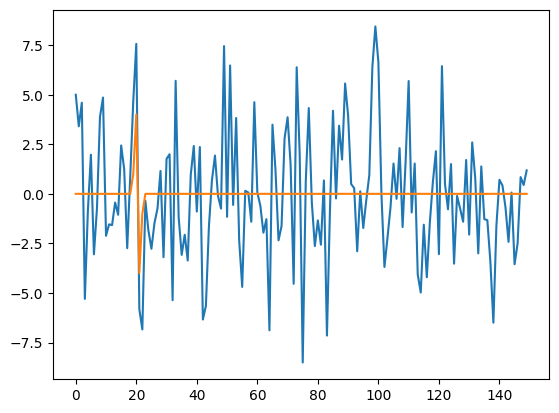

In [6]:
# plot
plt.plot(traces[1100:1250, 256])
plt.plot(traces_w[1100:1250, 256])

### (9m) Test KS3 on a sample butterworth-filt. recording (5 min)

* disable filtering commands in KS3 repository and set skip_preprocessing args to False (else does not find spikes). Note: all other preprocessing steps are enabled (whitening, mean subtraction, common referencing...).
* pass butterworth-preprocessed recording to the KS3 sorter
* that works (finds units)
* Sample takes 9 min copying as binary; very fast
* Sorting takes 36 mins

In [7]:
# params
sampling_frequency = 40000
duration_secs = 5 * 60

# sample
PreproSample = Prepro.frame_slice(
    start_frame=0, end_frame=int(duration_secs * sampling_frequency)
)

# save
PreproSample.save(
    folder=SAMPLE_PATH,
    format="binary",
    n_jobs=4,
    chunk_memory="40G",
    overwrite=True,
)

# run sorting (comment filtering commands in gpufilter.m from KS3 repo)
# % STEEVE - commented to disable filtering *****
# % next four lines should be equivalent to filtfilt (which cannot be used because it requires float64)
# %datr = filter(b1, a1, dataRAW); % causal forward filter
# %datr = flipud(datr); % reverse time
# %datr = filter(b1, a1, datr); % causal forward filter again
# %datr = flipud(datr); % reverse time back
# % STEEVE - commented to disable filtering *****

# testing sorting with the sample
# add these paths to sort_ks3_wavlt.py and run the sbatch command below
# test Butterworth preprocessed trace (5 min sample)
# PREPRO_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/trace_sample" # butterworth
# KS3_SORTING_PATH = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_sample/' # butter
# KS3_OUTPUT_PATH = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/KS3_output_sample/' # butter

# this takes 36 mins
# sbatch cluster/sorting/marques_silico/wavelet/sort_ks3.sbatch

write_binary_recording with n_jobs = 4 and chunk_size = 26041666


write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 12,000,000 samples 
                       300.00s (5.00 minutes) - float32 dtype - 17.17 GiB

#### Check actual trace preprocessed by KS3 

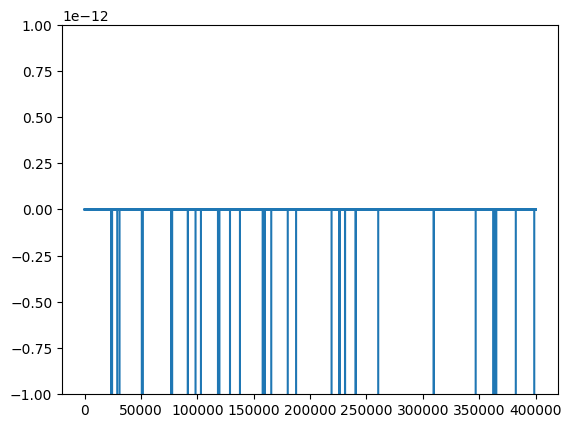

In [9]:
# load KS3 preprocessed file used for sorting and plot
ks3_prepro_file = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/KS3_output_sample/sorter_output/temp_wh.dat"
myarray = np.fromfile(ks3_prepro_file, dtype=float)
plt.plot(myarray[:400000])

* single unit count: 185
* mua count: 394


In [7]:
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_sample/"
)
print("single unit count", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

single unit count 185
mua count: 394


### (10m) Test KS3 on a sampled wavelet-filtd recording (5m)

* We disable the filtering commands in the KS3 repository, and set `skip_preprocessing` args to `False` (else it does not find any spike). Note: all other preprocessing steps are enabled (whitening, mean subtraction, common referencing...).
* We feed the waveleted-filtered recording to the KS3 sorter.

* KS3 trace copying (34.33 GiB) takes 9 mins (n_jobs=4, chunk_memory="40G"; 22 mins by default)
* Sorting takes 33m for a 5 min sample (float 32: 2h floa64)

* Saving with this generalizes to all machines (default chunk_memory='4G'):
```bash
Recording.save(
    folder=..,
    format="binary",
    n_jobs=-1,
)
```

This is much faster on our machines:

```bash
Recording.save(
    folder=SAMPLE_PATH_WVLT,
    format="binary",
    n_jobs=4,
    chunk_memory="40G",
    overwrite=True,
)
```

In [3]:
# params
sampling_frequency = 40000
duration_secs = 5 * 60

# sample
PreproSampleWlt = Prepro_w.frame_slice(
    start_frame=0, end_frame=int(duration_secs * sampling_frequency)
)

# save
PreproSampleWlt.save(
    folder=SAMPLE_PATH_WVLT,
    format="binary",
    n_jobs=4,
    chunk_memory="40G",
    overwrite=True,
)

# run sorting (comment filtering commands in gpufilter.m from KS3 repo)
# % STEEVE - commented to disable filtering *****
# % next four lines should be equivalent to filtfilt (which cannot be used because it requires float64)
# %datr = filter(b1, a1, dataRAW); % causal forward filter
# %datr = flipud(datr); % reverse time
# %datr = filter(b1, a1, datr); % causal forward filter again
# %datr = flipud(datr); % reverse time back
# % STEEVE - commented to disable filtering *****

# for wavelet
# PREPRO_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/trace_sample_wavelet"
# KS3_SORTING_PATH = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_sample_wvlt/'
# KS3_OUTPUT_PATH = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/KS3_output_sample_wvlt/'

# sort (takes 2h for 5 min (float64), 36 min (float32); 10 min (in16))
# and produces the same results
# sbatch cluster/sorting/marques_silico/wavelet/sort_ks3.sbatch

write_binary_recording with n_jobs = 72 and chunk_size = 40000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 12,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 8.58 GiB

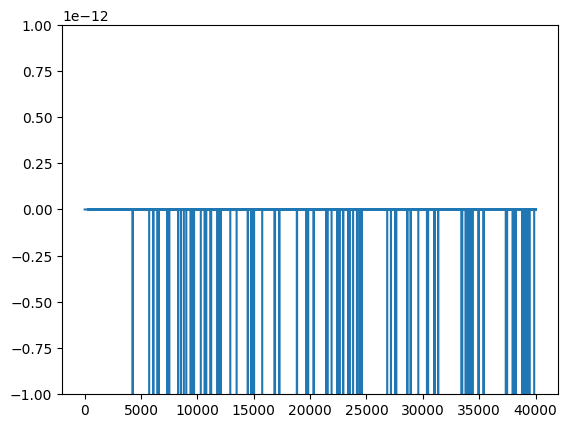

In [51]:
# load trace usedby KS3 for sorting and plot
ks3_trace_file = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/KS3_output_sample_wvlt/sorter_output/temp_wh.dat"
myarray = np.fromfile(ks3_trace_file, dtype=float)
plt.plot(myarray[:40000])

### Load SortingExtractor

* observations:
    * 5 times more single units are isolated.
    * a lot more multi-units too

* detection_threshold: 6
    * single unit count: 610
    * mua count: 1795
* detection_threshold: 12
    * single unit count: 574
    * mua count: 1655
* detection_threshold: 138
    * prediction: x2 -> -6% thus -> -70% (184) requires increasing the threshold 23X, thus 138.
    * actual: 
        * single unit count: 175 (174 for int16)
        * mua count: 639 (657 for int16)

In [5]:
SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_sample_wvlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))

single unit count: 174
mua count: 657


### Compare accuracies Butter. vs Wavelet

* Accuracies are not exact, as the ground truth is for the entire recording not the 5 first minutes.
* we plot butterworth-filtered vs. wavelet-filtered sortings with `detection_threshold=6`.

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


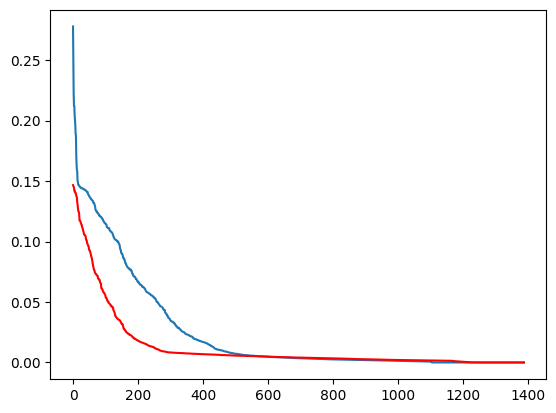

In [38]:
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# Butterworth-filtered
# agreement score between sorted and true units
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values)
plt.plot(accuracy_w.values, "r")

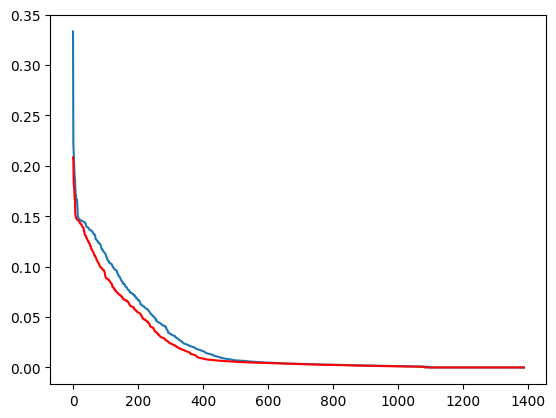

In [8]:
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# Butterworth-filtered
# agreement score between sorted and true units
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values)
plt.plot(accuracy_w.values, "r")

### (10m) Compare KS3 on butter vs. wavelet on the entire recording (40m)

* We disable the filtering commands in the KS3 repository, and set `skip_preprocessing` args to `False` (else it does not find any spike). Note: all other preprocessing steps are enabled (whitening, mean subtraction, common referencing...).
* We feed the waveleted-filtered recording to the KS3 sorter.

* KS3 trace is int16
* Sorting takes 1h

* detection_threshold: 138
    * single unit count: 316
    * mua count: 3149

* note: we had 5% accuracy with old KS3 on 10 min recording with Butterworth. What changed?


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 335
mua count: 1349
single unit count: 316
mua count: 3149

WAVELET
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388


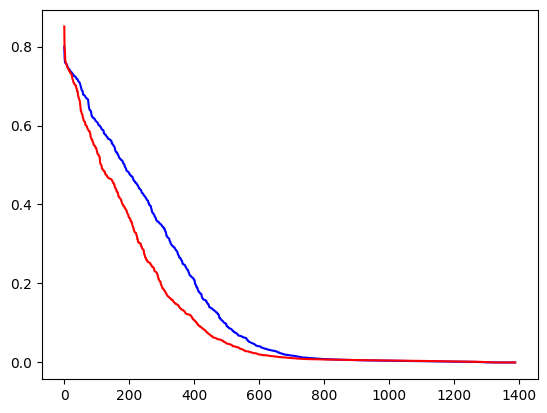

In [22]:
# get sorting extractors *****
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nWAVELET")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
print("# of well detected: ", sum(accuracy_w.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 228
mua count: 631
single unit count: 335
mua count: 1349
single unit count: 316
mua count: 3149

WAVELET
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH 10m
sorting accuracy:  0.0
# of well detected:  0
number of true units:  1388

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388


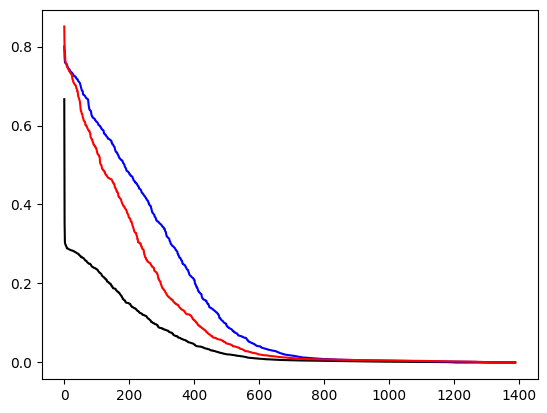

In [28]:
# get sorting extractors *****

# Butterworth 10 min
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
print("single unit count:", sum(SortingB10m.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m.get_property("KSLabel") == "mua"))

# Butter. entire
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

# wavelet
SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth 10m
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth entire
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b10m.values, "k")
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nWAVELET")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ", sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values)
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
print("# of well detected: ", sum(accuracy_w.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 228
mua count: 631
single unit count: 228
mua count: 613
single unit count: 335
mua count: 1349

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH 10m
sorting accuracy:  0.05343511450381679
# of well detected:  70
number of true units:  1388

BUTTERWORTH 10m01005
sorting accuracy:  0.05267175572519084
# of well detected:  69


AttributeError: 'Series' object has no attribute 'unit_ids'

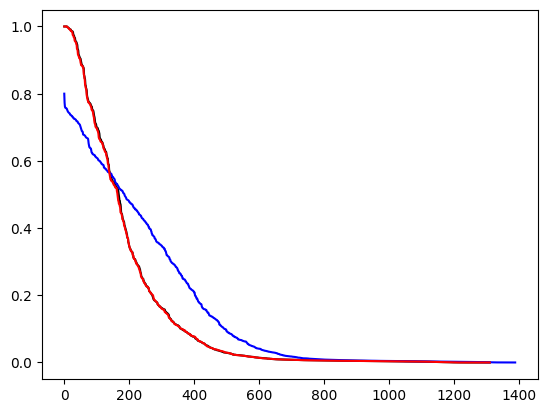

In [32]:
# get sorting extractors *****

# Butterworth 10 min (done with si0961)
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
print("single unit count:", sum(SortingB10m.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m.get_property("KSLabel") == "mua"))

# Butterworth 10 min (done with si01005)
SortingB10m01005 = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_si01005/"
)
print("single unit count:", sum(SortingB10m01005.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m01005.get_property("KSLabel") == "mua"))

# Butter. entire (done with si0961)
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

# wavelet (done with si01005 - incompatbility)
# SortingW = si.load_extractor(
#     "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
# )
# print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
# print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units (done with si0961)
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth 10m
SortingTrue10m = si.load_extractor(SORTING_TRUE_PATH_10m)
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth 10m01005
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m01005, exhaustive_gt=True
)
accuracy_b10m01005 = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth entire
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
# matching = comparison.compare_sorter_to_ground_truth(
#     SortingTrue, SortingW, exhaustive_gt=True
# )
# accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b10m.values, "k")
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_b10m01005.values, "r")

# plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))


print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ", sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values)
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH 10m01005")
print(
    "sorting accuracy: ",
    sum(accuracy_b10m01005.values >= 0.8) / len(accuracy_b10m01005.values),
)
print("# of well detected: ", sum(accuracy_b10m01005.values >= 0.8))
print("number of true units: ", len(accuracy_b10m01005.unit_ids))

# print("\nWAVELET")
# print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
# print("# of well detected: ", sum(accuracy_w.values >= 0.8))
# print("number of true units: ", len(SortingTrue.unit_ids))

In [2]:
# butterworth 10m
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)


print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ",
    sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values),
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue10m.unit_ids))

single unit count 354
mua count: 1058
single unit count 227
mua count: 437


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(



BUTTERWORTH 10m
sorting accuracy:  0.05343511450381679
# of well detected:  70
number of true units:  1310

BUTTERWORTH 10m rotd 10m....
sorting accuracy:  0.04122137404580153
# of well detected:  54
number of true units:  1310

BUTTERWORTH rotd full
sorting accuracy:  0.0
# of well detected:  0
number of true units:  1388


### (6m) Save as int16 to speed up sorting

In [5]:
Wired = si.load_extractor(WIRED_PATH_10m)

# convert to int16
Wired = spre.astype(Wired, "int16")

# save
Wired.save(
    folder=WIRED_PATH_10m_int16,
    format="binary",
    n_jobs=4,
    chunk_memory="40G",
    overwrite=True,
)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


write_binary_recording with n_jobs = 4 and chunk_size = 52083333


write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 23,519,988 samples 
                       588.00s (9.80 minutes) - int16 dtype - 16.82 GiB